# Deep Learning for Doodle Classification

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
DATA_PATH = './data/processed/'
NFOLDS = 5

## Functions

Reads `.bin` file.

In [3]:
import struct
from struct import unpack
import numpy as np

def unpack_drawing(file_handle):
    image = unpack(f'{IMAGE_HEIGHT * IMAGE_WIDTH}B', file_handle.read(IMAGE_HEIGHT * IMAGE_WIDTH))
    image = np.array(image, ndmin=2)
    image.shape = (-1, IMAGE_WIDTH)
    
    return image

def unpack_drawings(filename):
    with open(filename, 'rb') as f:
        while True:
            try:
                yield unpack_drawing(f)
            except struct.error:
                break

Draw doodle

In [4]:
import matplotlib.pyplot as plt

def draw_doodle(doodle, label, text_offset=5):
    plt.imshow(doodle, cmap='gray', vmin=0, vmax=255)
    plt.text(
        IMAGE_WIDTH / 2, IMAGE_HEIGHT + text_offset, 
        label.title(),
        size = 20,
        horizontalalignment='center',
        verticalalignment='top'
    )
    plt.axis('off')
    plt.show()

## Reading the data

In [5]:
X = []
y = []

X_test = []
y_test = []

X_val = []
y_val = []

In [6]:
import os

for category in os.listdir(DATA_PATH):
    if(category == '.DS_Store'):
        continue
    print(f'Reading: {category};')
    
    validation_path = os.path.join(DATA_PATH, category, 'validation.bin')
    for drawing in unpack_drawings(validation_path):
        X_val.append(drawing)
        y_val.append(category)
    
    test_path = os.path.join(DATA_PATH, category, 'test.bin')
    for drawing in unpack_drawings(test_path):
        X_test.append(drawing)
        y_test.append(category)

    train_path = os.path.join(DATA_PATH, category, 'train')
    for fold in os.scandir(train_path):
        for drawing in unpack_drawings(os.path.join(train_path, f'{fold.name}')):
            if fold.name == '.DS_Store':
                continue
            X.append(drawing)
            y.append(category)

Reading: diamond;
Reading: cat;
Reading: eye;
Reading: cup;
Reading: angel;
Reading: plant;
Reading: dolphin;
Reading: windmill;
Reading: helicopter;
Reading: headphones;
Reading: umbrella;
Reading: house;
Reading: eyeglasses;
Reading: hat;
Reading: octopus;
Reading: ship;
Reading: bicycle;
Reading: popsicle;
Reading: clock;
Reading: door;


Drawing an example

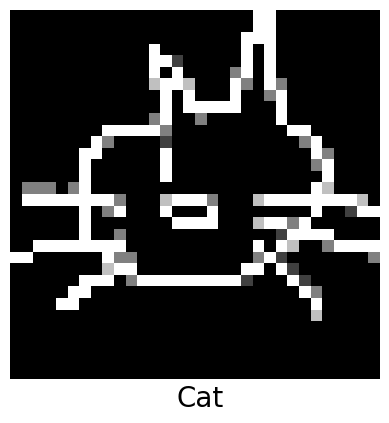

In [9]:
for drawing in unpack_drawings(os.path.join('./data', 'processed', 'cat', 'validation.bin')):
    draw_doodle(drawing, 'cat', 0)
    break

## Preprocessing

Transforming labels from text format to integer

In [10]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)

y = le.transform(y)
y = np.array(y)

y_test = le.transform(y_test)
y_test = np.array(y_test)

y_val = le.transform(y_val)
y_val = np.array(y_val)

X = np.array(X)
X_test = np.array(X_test)
X_val = np.array(X_val)

X.shape = (X.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1)
X_test.shape = (X_test.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1)
X_val.shape = (X_val.shape[0], IMAGE_HEIGHT, IMAGE_WIDTH, 1)

Testing transformation

In [11]:
le.inverse_transform(np.unique(y_test))

array(['angel', 'bicycle', 'cat', 'clock', 'cup', 'diamond', 'dolphin',
       'door', 'eye', 'eyeglasses', 'hat', 'headphones', 'helicopter',
       'house', 'octopus', 'plant', 'popsicle', 'ship', 'umbrella',
       'windmill'], dtype='<U10')

In [12]:
print(np.unique(y_test))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


## Data visualization

In [13]:
import matplotlib.ticker as mtick

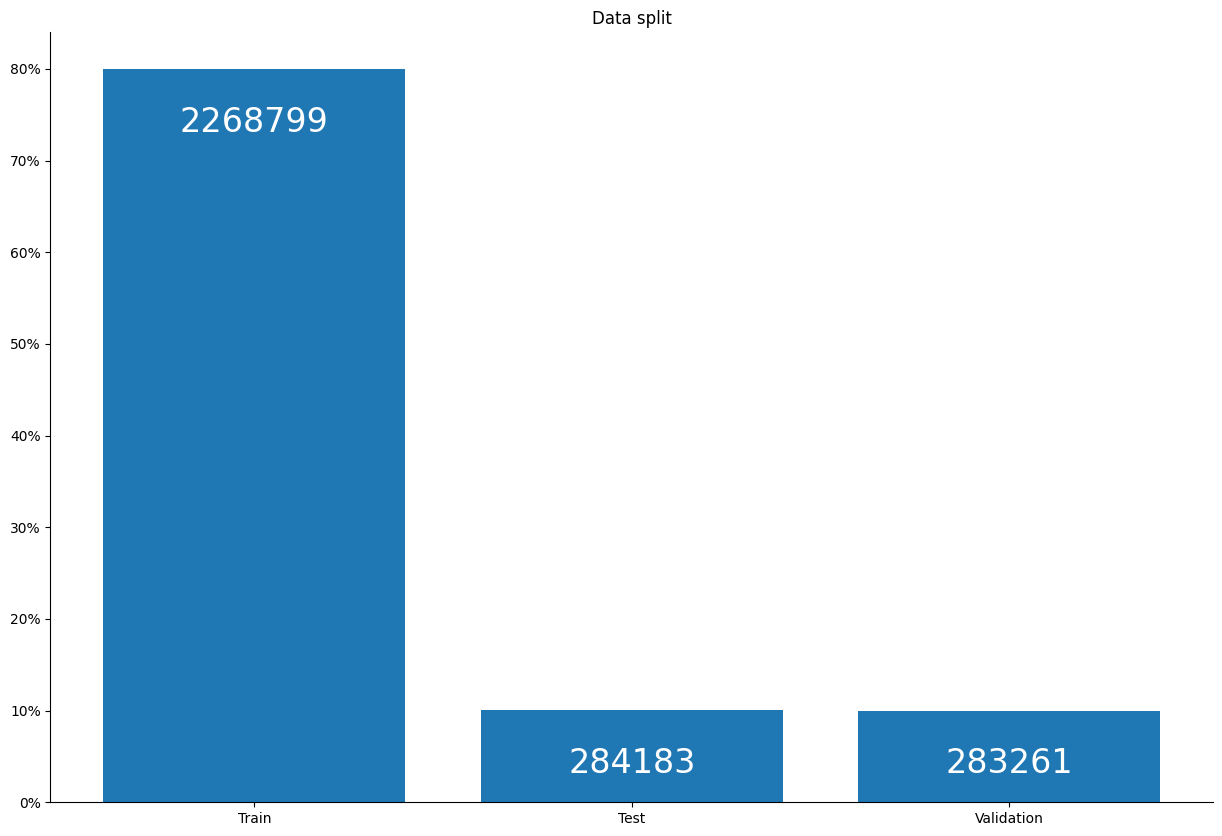

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

splits = ['Train', 'Test', 'Validation']
splits_sizes = [X.shape[0], X_test.shape[0], X_val.shape[0]]
sum_shape = np.sum(splits_sizes)

split_prop = splits_sizes / sum_shape

ax.bar(
    splits, 
    split_prop
)

for i, split in enumerate(splits): 
    ax.text(
        i,
        split_prop[i] - 0.04,
        splits_sizes[i],
        horizontalalignment='center',
        verticalalignment='top',
        c='w',
        size=24 
    )
    

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Data split')

fig.show()

In [15]:
unique, counts = np.unique(y, return_counts=True)

sort = np.argsort(counts)[::-1][:len(counts)]
unique = unique[sort]
counts = counts[sort]
counts_prop = (counts / np.sum(counts)) * 100

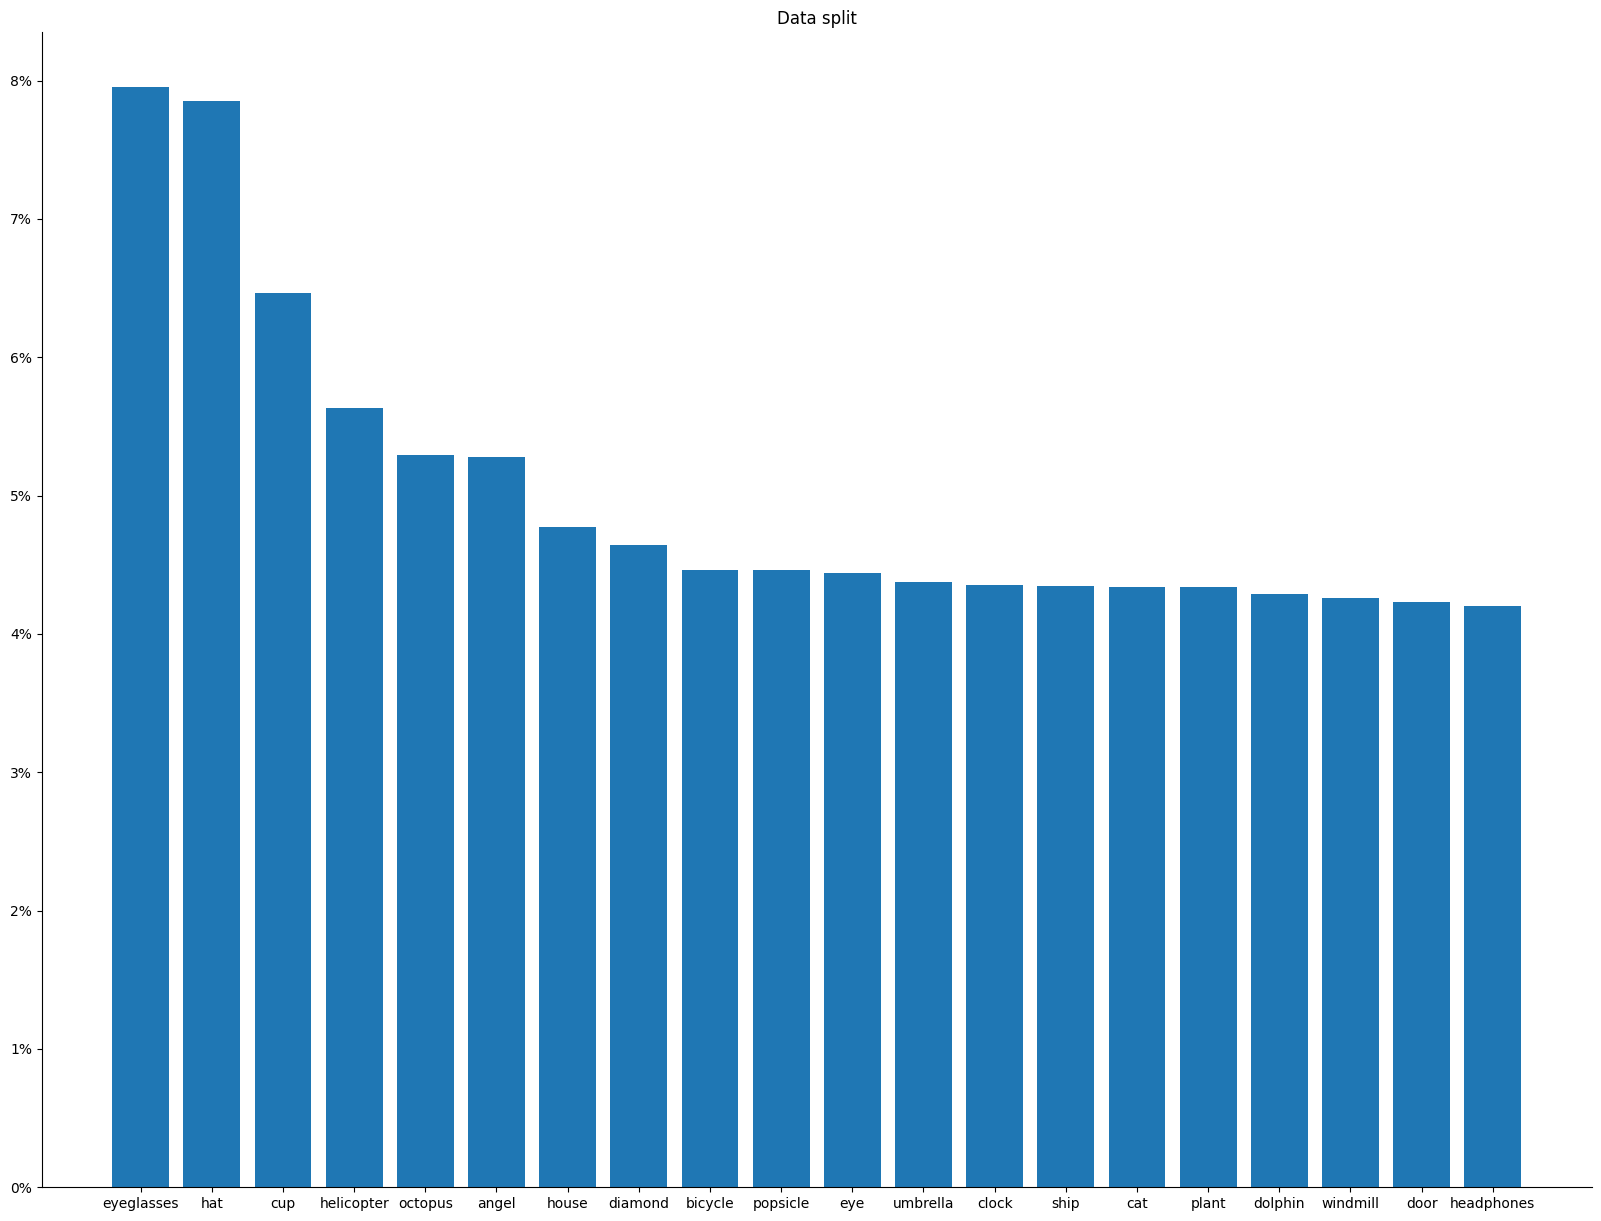

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
unique = le.inverse_transform(unique)

ax.bar(
    unique, 
    counts_prop
)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Data split')

fig.show()

In [17]:
nclasses = len(set(y))
nclasses

20

## Deep Learning

In [18]:
import tensorflow as tf
from tensorflow import keras

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Defining a generator, data is too big to fit memory while training.

In [20]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_gen = DataGenerator(X, y, 32)
val_gen = DataGenerator(X_val, y_val, 32)
test_gen = DataGenerator(X_test, y_test, 32)

Defifning models

In [21]:
model_conv = keras.Sequential([
    keras.layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 1)),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(784, activation='relu'),
    keras.layers.Dense(300, activation='relu'),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(nclasses, activation='softmax')    
])


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-12-19 01:36:19.793051: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-19 01:36:19.793381: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
model_conv.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Max Number of Epochs

In [23]:
nepochs = 10

Defining Callbacks

In [24]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='./model/checkpoints/model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./model/logs'),
]

Cross-validation

Training

In [25]:
history_conv = model_conv.fit(
    train_gen, 
    epochs=nepochs, 
    validation_data=val_gen, 
    verbose=1, 
    shuffle=True, 
    callbacks=my_callbacks
)

Epoch 1/10


2022-12-19 01:36:20.130180: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-19 01:36:20.463693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70900/70900 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.9204

2022-12-19 01:55:07.158509: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


70900/70900 [==============================] - 1180s 17ms/step - loss: 0.2912 - accuracy: 0.9204 - val_loss: 0.2159 - val_accuracy: 0.9434
Epoch 2/10
70900/70900 [==============================] - 1178s 17ms/step - loss: 0.1908 - accuracy: 0.9490 - val_loss: 0.2104 - val_accuracy: 0.9461
Epoch 3/10
70900/70900 [==============================] - 1176s 17ms/step - loss: 0.1718 - accuracy: 0.9541 - val_loss: 0.2013 - val_accuracy: 0.9477
Epoch 4/10
70900/70900 [==============================] - 1176s 17ms/step - loss: 0.1616 - accuracy: 0.9571 - val_loss: 0.2005 - val_accuracy: 0.9483
Epoch 5/10
70900/70900 [==============================] - 1177s 17ms/step - loss: 0.1525 - accuracy: 0.9596 - val_loss: 0.2007 - val_accuracy: 0.9493
Epoch 6/10
70900/70900 [==============================] - 1176s 17ms/step - loss: 0.1485 - accuracy: 0.9611 - val_loss: 0.2192 - val_accuracy: 0.9459


## Model Conv Performance Visualization

In [26]:
from matplotlib.ticker import MaxNLocator

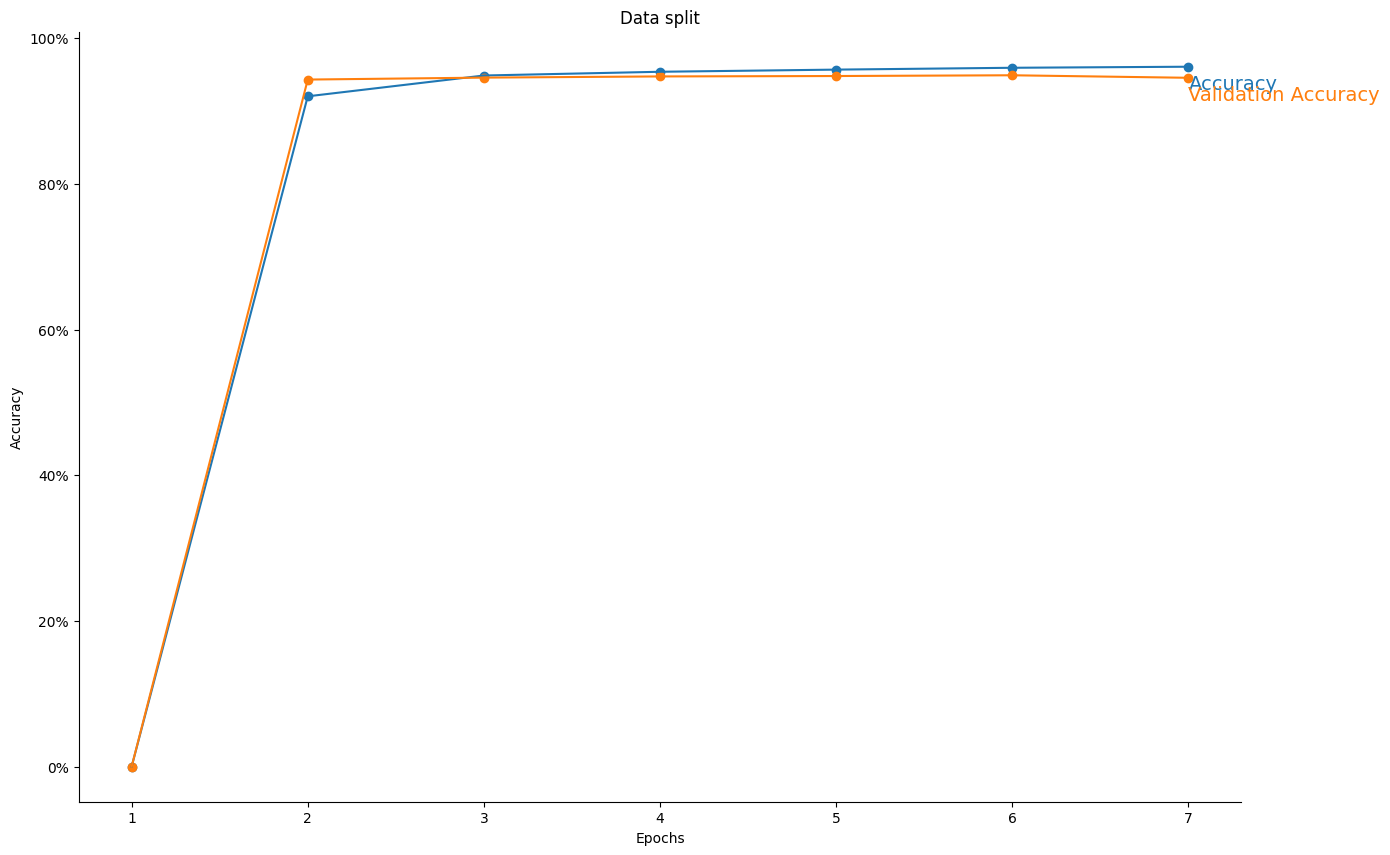

In [27]:
n = len(history_conv.history['accuracy'])
accuracy = np.zeros(n + 1)
val_accuracy = np.zeros(n + 1)

for i in range(n):
    accuracy[i + 1] = history_conv.history['accuracy'][i]
    val_accuracy[i + 1] = history_conv.history['val_accuracy'][i]

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

epochs = [(i + 1) for i in range(n + 1)]

ax.plot(
    epochs,
    accuracy,
)

ax.plot(
    epochs, 
    val_accuracy
)

ax.scatter(epochs, accuracy)
ax.scatter(epochs, val_accuracy)

ax.xaxis.set_major_locator(MaxNLocator(integer=True))


labels = ['Accuracy', 'Validation Accuracy']

colors = ['#1f77b4', '#ff7f0e']
for i, value in enumerate([accuracy[-1], val_accuracy[-1]]): 
    ax.text(
        n + 1,
        value - 0.01,
        labels[i],
        c=colors[i],
        horizontalalignment='left',
        verticalalignment='top',
        size=14
    )
    
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Data split')

fig.show()

In [28]:
predictions = model_conv.predict(X_test)

  12/8881 [..............................] - ETA: 43s    

2022-12-19 03:34:05.512004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8881/8881 [==============================] - 37s 4ms/step


### Confusion Matrix

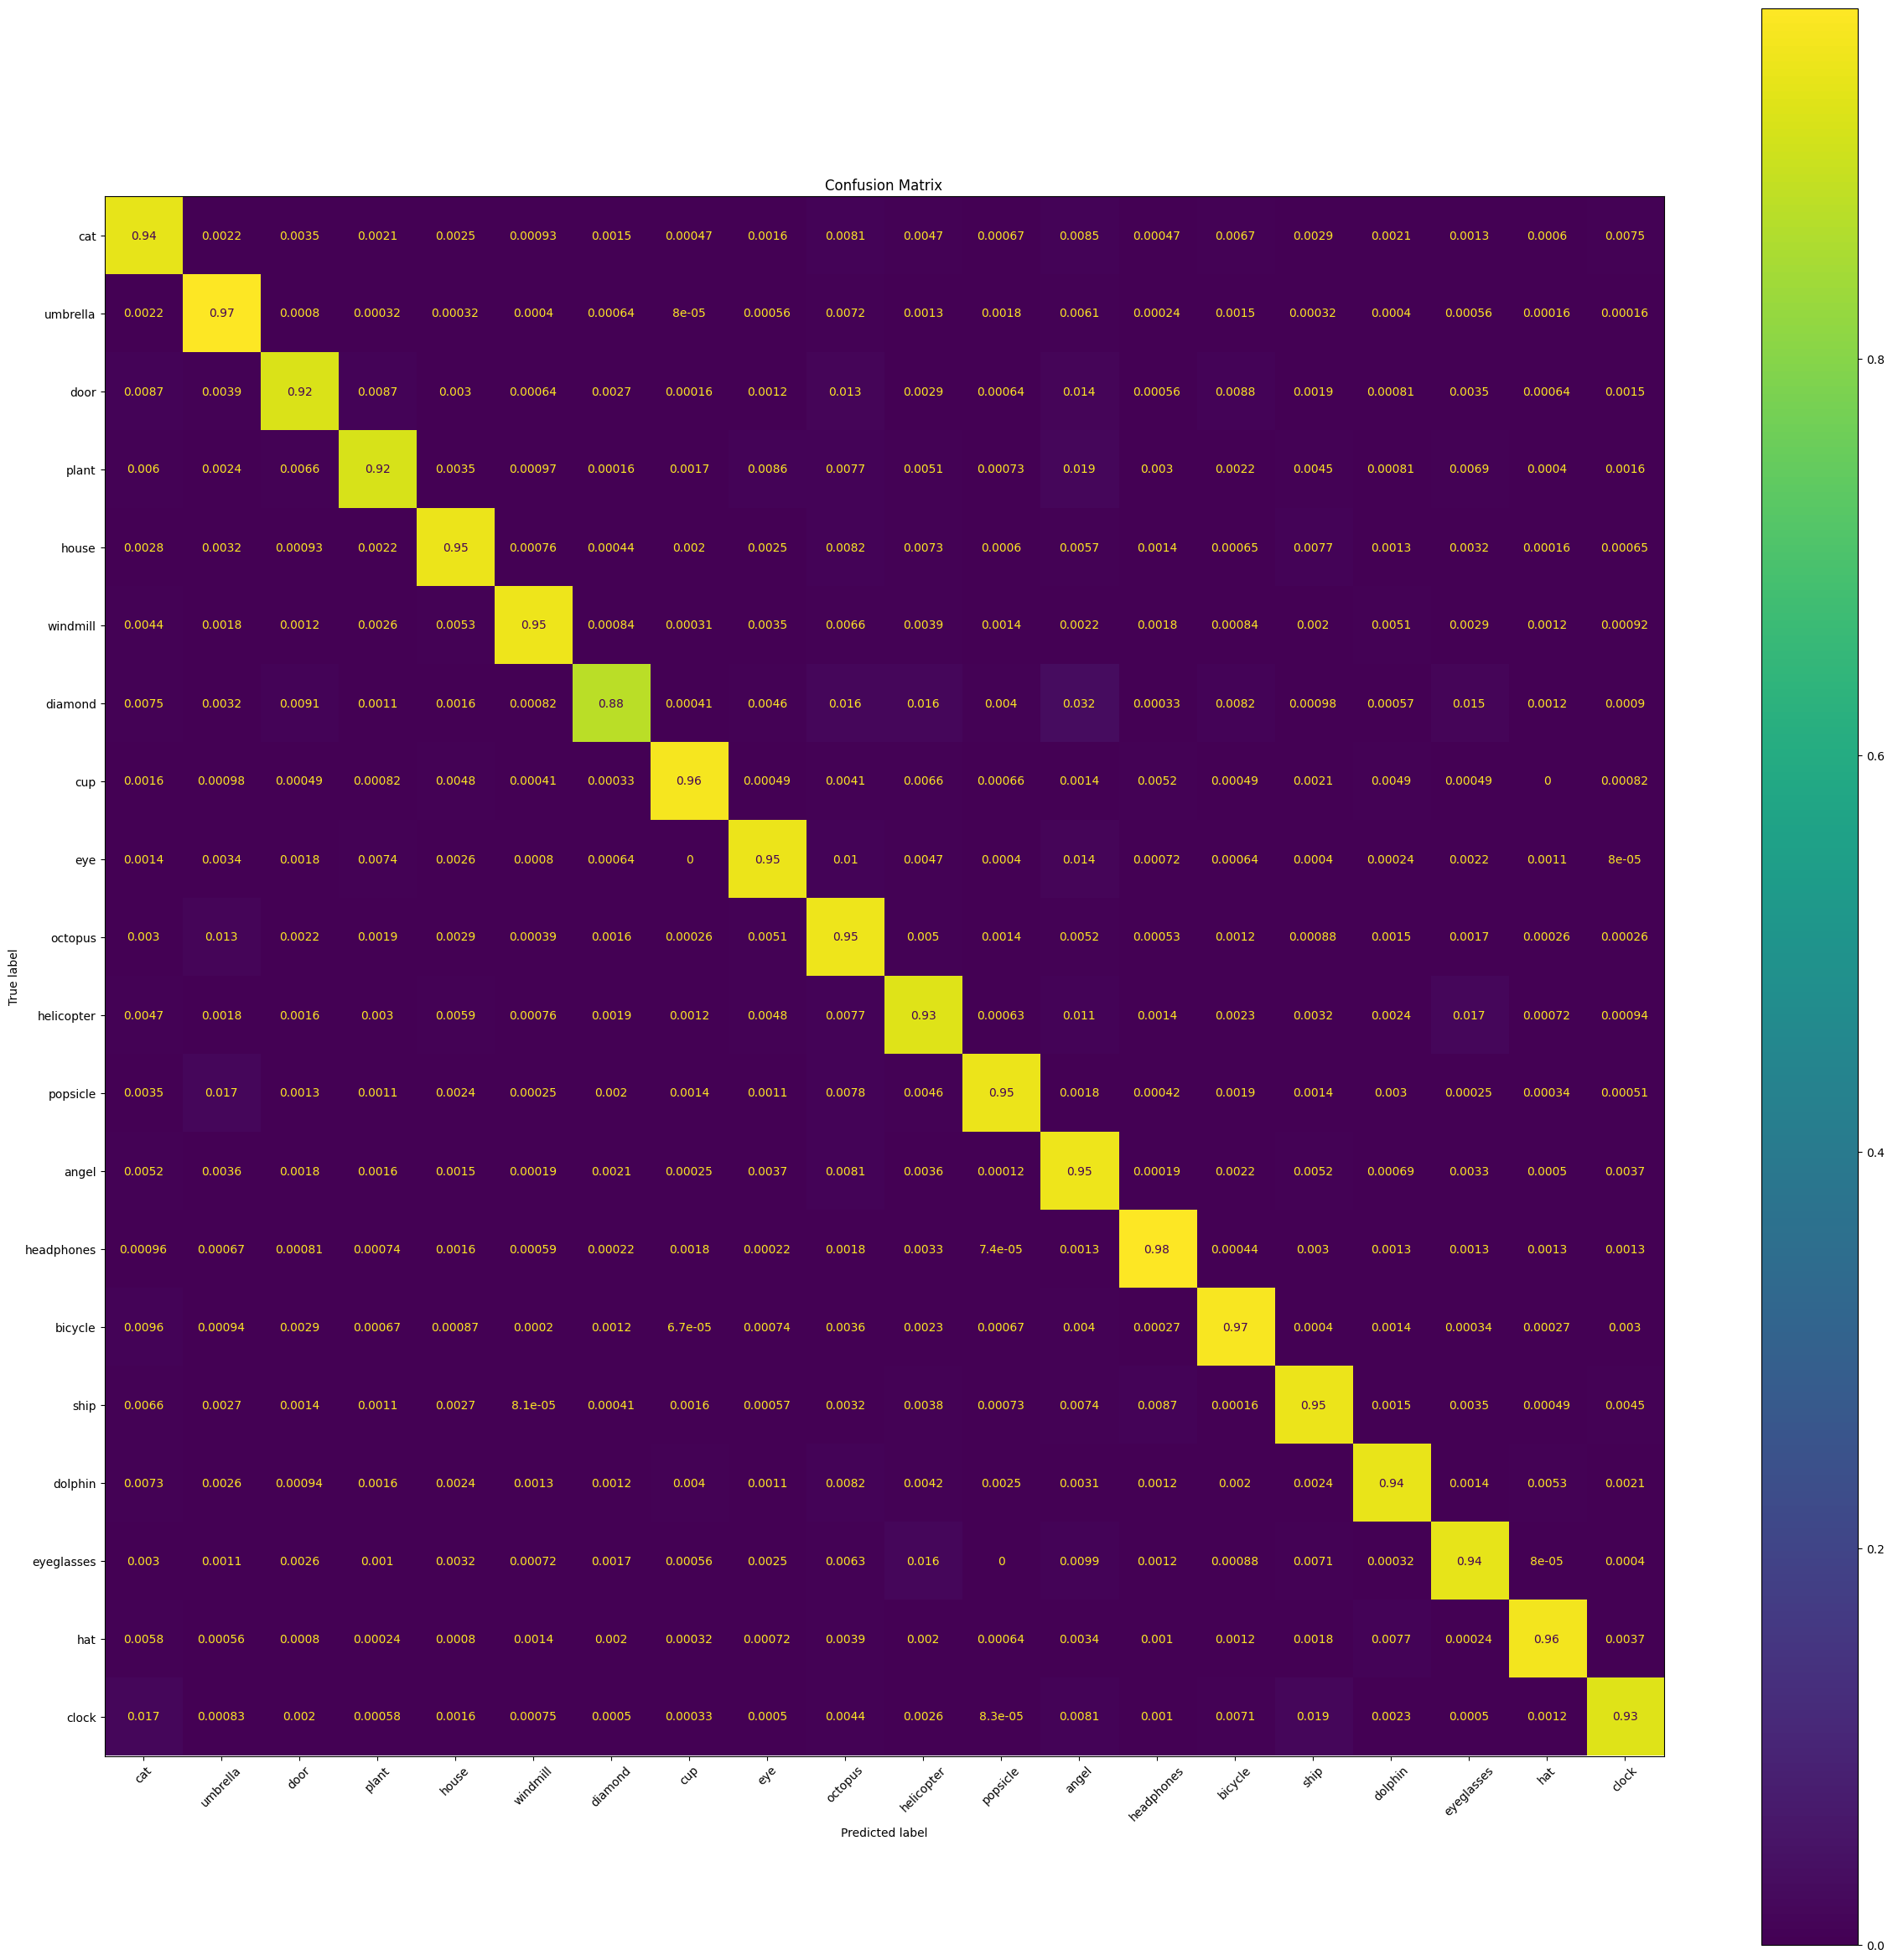

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = [le.inverse_transform(np.argmax(pred).reshape(-1,1))[0] for pred in predictions]
cf_matrix = confusion_matrix(le.inverse_transform(y_test), y_pred, normalize='true')


disp = ConfusionMatrixDisplay(cf_matrix, display_labels=set(le.inverse_transform(y_test)))

fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax, xticks_rotation=45)

disp.ax_.set_title('Confusion Matrix')
# disp.im_.colorbar.remove()
disp.ax_.set_xlabel('Predicted label')

plt.show()

### More metrics

F1 Score

In [30]:
from sklearn.metrics import f1_score, accuracy_score

In [31]:
accuracy = accuracy_score(
    le.inverse_transform(y_test), y_pred
)
accuracy

0.9449580024139375

In [32]:
f1 = f1_score(
    le.inverse_transform(y_test), y_pred, 
    labels = list(set(le.inverse_transform(y_test))), 
    average = 'micro'
)
f1

0.9449580024139375

Saving final model

In [33]:
model_conv.save('./model/doodles.h5', include_optimizer=False)

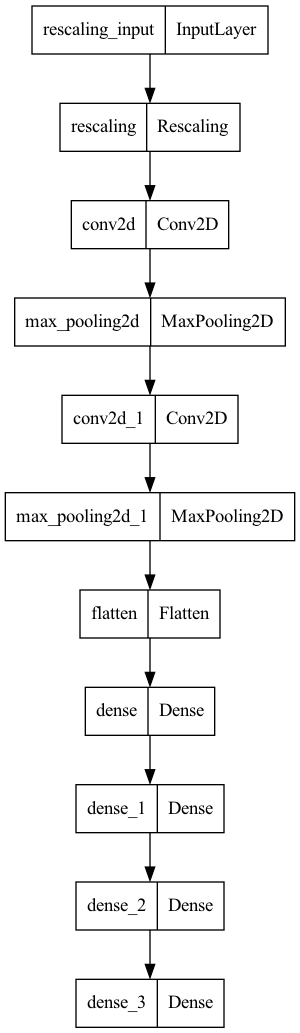

: 

In [34]:
tf.keras.utils.plot_model(
    model_conv,
    to_file='topology.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)